# Self vs Neighbor Effects (Spillovers): Two Outcome Modes

This notebook demonstrates two causal outcome-generating settings on graphs and trains a matching attention model accordingly.

- Outcome mode: "with_self" (single-head)
  - Assumption: Self is part of the normalized attention over one-hop neighbors (including the node itself).
  - Outcome: y_i = sum_j w_ij(X_i, X_j) T_j + U_0(X_i) + noise.
  - Model: One-head attention GCN learns f(X_i, X_j) and normalizes across self + neighbors.

- Outcome mode: "separate_self" (two-head)
  - Assumption: Self is not included in neighbor normalization; self-treatment enters separately.
  - Outcome: y_i = g(X_i) T_i + sum_{j in N(i)} w_ij(X_i, X_j) T_j + U_0(X_i) + noise.
  - Model: Two-head attention GCN learns g(X_i) for direct effect and f(X_i, X_j) for spillovers, normalizing only over neighbors j ≠ i.

What you control
- Set `outcome_mode` to either "with_self" or "separate_self" in the config cell.
- The pipeline adapts simulation, training, and evaluation to match the chosen mode.

Outputs reported
- Individual Main Effect (IME): direct (self) effect per node.
- Individual Spillover Effect (ISE): neighbor-induced effect per node.
- Individual Total Effect (ITE): IME + ISE.
- We compare true vs estimated effects and report AME and PEHE.



In [1]:
import numpy as np
import torch 
from utils import load_data, plot_true_vs_pred
from simulation import simulate_treatment, compute_outcome
from train import (
    GraphData,
    TrainConfig,
    PropensityConfig,
    MeanConfig,
    AttentionConfig,
    fit_propensity,
    fit_mean,
    fit_attention,
)
from metric import (
    compute_individual_effects,
    evaluate,
    compute_dbml_baseline,
)


### Config

In [ ]:
# Config
path = "Flickr_New.npz"  # or "BC_New.npz"
feature_name = "lda_supervised"
fold_num = 2

# Outcome mode: "with_self" (current) or "separate_self" (new)
outcome_mode = "separate_self"  # change between "with_self" and "separate_self"
include_self_loop = (outcome_mode == "with_self")
low_dimension = False  # explicitly use full X for f and g in this notebook

# Attention similarities
f_type = "cosine"  # neighbor attention f(X_i, X_j)
g_type = "heter"   # self treatment g(X_i) (used only in separate_self mode)
attn_temperature = 0

# Hyperparams
beta = 1
alpha = 2
sigma = 0.05
scale = 5
num_partition = 3

# Ratio between self and neighbor contributions (separate_self only)
ratio_self = 1.0

# Load data
X, A, X_val, A_val, X_test, A_test = load_data(path, feature_name, fold_num)


### Semi-synthetic data generation 

In [ ]:
# Simulate treatment and outcome according to outcome_mode
nbrs_idx, n, d, partitions, t, e_star, treat_neighbor, treat_matrix = simulate_treatment(
    X, A, mode="train", beta=beta, alpha=alpha, num_partitions=num_partition, include_self_loop=include_self_loop
)

# Unified treatment/outcome
true_attention, spillover, U_0, noise, y, m_star, g_true = compute_outcome(
    X, A, treat_matrix, e_star, n, sigma, scale, attn_temperature, name=f_type,
    outcome_mode=outcome_mode, self_name=g_type, t=t,
    w_self=ratio_self
)

# Define IME/ISE/ITE for training via unified function
IME, ISE, ITE = compute_individual_effects(true_attention, A, outcome_mode=outcome_mode, g_self=g_true)

# test split
nbrs_idx_test, n_test, d_test, partitions_test, t_test, e_star_test, treat_neighbor_test, treat_matrix_test = simulate_treatment(
    X_test, A_test, mode="test", beta=beta, alpha=alpha, include_self_loop=include_self_loop
)
true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test, g_true_test = compute_outcome(
    X_test, A_test, treat_matrix_test, e_star_test, n_test, sigma, scale, attn_temperature, name=f_type,
    outcome_mode=outcome_mode, self_name=g_type, t=t_test,
    w_self=ratio_self
)

# Define IME/ISE/ITE for test via unified function
IME_test, ISE_test, ITE_test = compute_individual_effects(true_attention_test, A_test, outcome_mode=outcome_mode, g_self=g_true_test)



In [4]:
IME

array([-0.22921572,  0.24294098, -0.22627126, ...,  0.44052697,
       -0.15356216,  0.11504557], shape=(4544,))

In [5]:
ISE

array([ 0.12485303,  0.56563145,  0.02154857, ...,  0.23301423,
       -0.35218881,  0.75403154], shape=(4544,))

### Fitting nuisance components

In [7]:
# Train configs
train_cfg_pm = TrainConfig(epochs=200, lr=5e-2, batch_size=n, patience=12, device="cpu", log_every=40)

prop_cfg = PropensityConfig(hidden_dim=128)
mean_cfg = MeanConfig(hidden_dim=128)

data = GraphData(X=X, y=y, A=A, nbrs_idx=nbrs_idx, t=t, fold_assignments=partitions)

fr_p, data = fit_propensity(data, train_cfg_pm, prop_cfg)
fr_m, data = fit_mean(data, train_cfg_pm, mean_cfg)

[propensity] Fold 0, Epoch 040 | train loss: 0.391435 | fold_loss: 0.381164
[propensity] Fold 0, Epoch 080 | train loss: 0.373270 | fold_loss: 0.400952
[propensity] Fold 0, Epoch 120 | train loss: 0.349190 | fold_loss: 0.446313
[propensity] Fold 0, Epoch 160 | train loss: 0.335175 | fold_loss: 0.483740
[propensity] Fold 0, Epoch 200 | train loss: 0.326359 | fold_loss: 0.525323
[propensity] Fold 1, Epoch 040 | train loss: 0.374799 | fold_loss: 0.420928
[propensity] Fold 1, Epoch 080 | train loss: 0.355809 | fold_loss: 0.424083
[propensity] Fold 1, Epoch 120 | train loss: 0.334970 | fold_loss: 0.447322
[propensity] Fold 1, Epoch 160 | train loss: 0.317607 | fold_loss: 0.483981
[propensity] Fold 1, Epoch 200 | train loss: 0.298234 | fold_loss: 0.489585
[propensity] Fold 2, Epoch 040 | train loss: 0.374922 | fold_loss: 0.411373
[propensity] Fold 2, Epoch 080 | train loss: 0.355287 | fold_loss: 0.428628
[propensity] Fold 2, Epoch 120 | train loss: 0.331978 | fold_loss: 0.456218
[propensity]

19.75574713134652
16.833393588270386


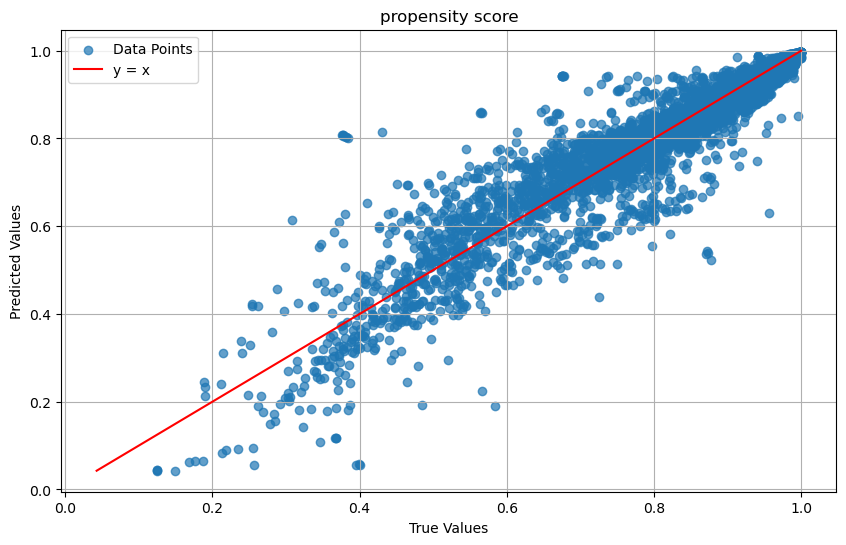

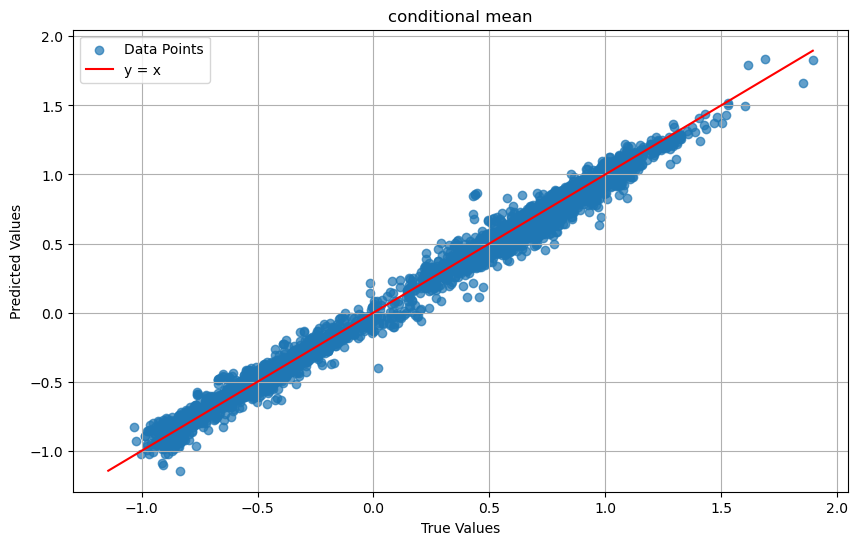

In [8]:
mu_hat = data.mu_hat
e_hat = data.e_hat

print(np.sum((mu_hat-m_star)**2))
print(np.sum((e_hat-e_star)**2))

plot_true_vs_pred(e_hat,e_star,title_name="propensity score")
plot_true_vs_pred(mu_hat,m_star,title_name="conditional mean")

### Fitting causal effect

In [11]:
data.mu_hat=m_star
data.e_hat=e_star

In [12]:
# Fit attention
train_cfg_attn = TrainConfig(epochs=400, lr=1e-4, batch_size=64, patience=12, device="cpu", log_every=1)
# attention config switches model behavior
attn_cfg = AttentionConfig(hidden_dim=64, attn_temperature=attn_temperature, separate_self=(outcome_mode=="separate_self"))

# Single call: g_true is None in with_self, provided in separate_self
fr_a = fit_attention(data, train_cfg_attn, attn_cfg, attn_true=true_attention, attn_true_self=g_true)

print("Done fitting attention.")

Epoch 001, New best Spillover diff: 407.0870
Epoch 002, New best Spillover diff: 265.7859
Epoch 003, New best Spillover diff: 193.4509
Epoch 004, New best Spillover diff: 147.6545
Epoch 005, New best Spillover diff: 120.1152
Epoch 006, New best Spillover diff: 102.9196
Epoch 007, New best Spillover diff: 91.0695
Epoch 008, New best Spillover diff: 83.2941
Epoch 009, New best Spillover diff: 76.1054
Epoch 010, New best Spillover diff: 70.0035
Epoch 011, New best Spillover diff: 65.6894
Epoch 012, New best Spillover diff: 61.8821
Epoch 013, New best Spillover diff: 58.0806
Epoch 014, New best Spillover diff: 54.8991
Epoch 015, New best Spillover diff: 52.3382
Epoch 016, New best Spillover diff: 49.9872
Epoch 017, New best Spillover diff: 47.4814
Epoch 018, New best Spillover diff: 45.4382
Epoch 019, New best Spillover diff: 43.9025
Epoch 020, New best Spillover diff: 41.9603
Epoch 021, New best Spillover diff: 40.7242
Epoch 022, New best Spillover diff: 39.6448
Epoch 023, New best Spillo

Proposed: training set
IME: AME = 0.00406, PEHE = 0.00712
ISE: AME = -0.00932, PEHE = 0.05460
ITE: AME = -0.00526, PEHE = 0.05630
Proposed: testing set
IME: AME = 0.00416, PEHE = 0.00748
ISE: AME = -0.01198, PEHE = 0.07297
ITE: AME = -0.00782, PEHE = 0.07355


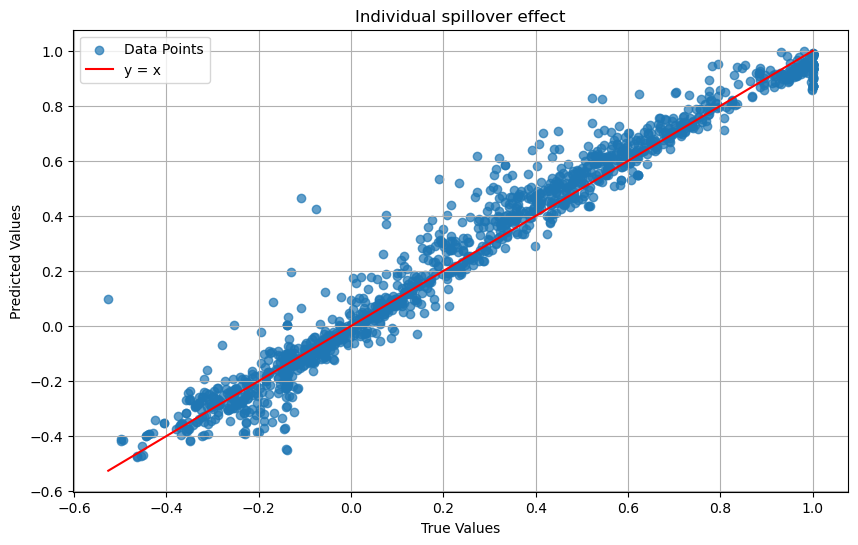

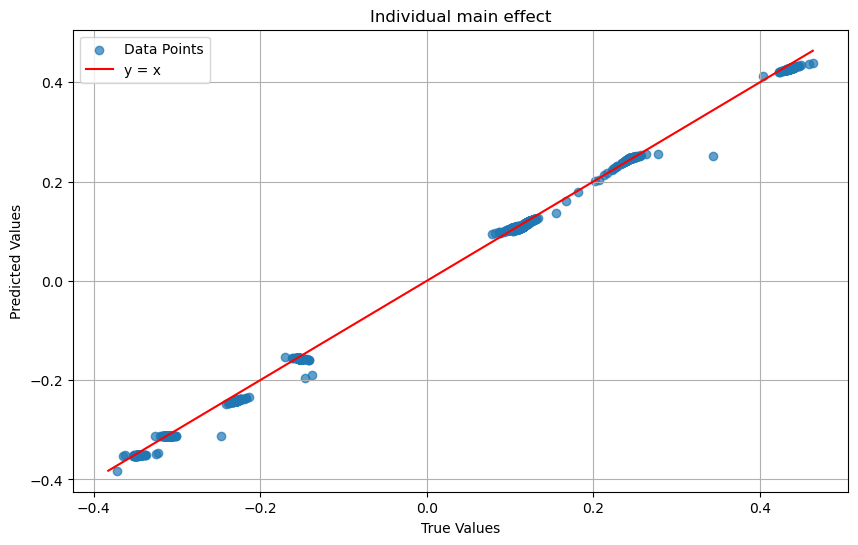

In [13]:
# Unified estimation from model
import torch 
with torch.no_grad():
  out = fr_a.model.cpu().predict(torch.tensor(X, dtype=torch.float32), nbrs_idx, torch.tensor(t, dtype=torch.float32))
W_pred, g_pred = (out[0], out[2]) if isinstance(out, tuple) and len(out) == 3 else (out[0], None)
IME_est, ISE_est, ITE_est = compute_individual_effects(W_pred, A, outcome_mode, g_self=g_pred)
print("Proposed: training set")
Result_train=evaluate(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=True)

with torch.no_grad():
  out_test = fr_a.model.predict(torch.tensor(X_test, dtype=torch.float32), nbrs_idx_test, torch.tensor(t_test, dtype=torch.float32))
W_pred_test, g_pred_test = (out_test[0], out_test[2]) if isinstance(out_test, tuple) and len(out_test) == 3 else (out_test[0], None)
IME_est_test, ISE_est_test, ITE_est_test = compute_individual_effects(W_pred_test, A_test, outcome_mode, g_self=g_pred_test)
print("Proposed: testing set")
Result_test=evaluate(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=True)

plot_true_vs_pred(ISE_test,ISE_est_test,title_name="Individual spillover effect")
plot_true_vs_pred(IME_test,IME_est_test,title_name="Individual main effect")

# Proposed: training set
# IME: AME = 0.00829, PEHE = 0.01341
# ISE: AME = 0.01433, PEHE = 0.06569
# ITE: AME = 0.02262, PEHE = 0.06955
# Proposed: testing set
# IME: AME = 0.00865, PEHE = 0.01371
# ISE: AME = 0.02204, PEHE = 0.08944
# ITE: AME = 0.03069, PEHE = 0.09334

### Compute baseline

In [30]:
# DBML baseline metric on training set
IME_db, ISE_db, ITE_db, beta_hat = compute_dbml_baseline(y, data.mu_hat, data.e_hat, A, n, t)
print("DBML baseline: training set")
_ = evaluate(IME, ISE, ITE, IME_db, ISE_db, ITE_db, printing=True)


DBML baseline: training set
IME: AME = 0.00039, PEHE = 0.25391
ISE: AME = 0.10242, PEHE = 0.33448
ITE: AME = 0.10281, PEHE = 0.49392
